In [2]:
import os
import blpapi
from xbbg import blp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
import base64
import webbrowser
path = r"C:/Users/ky090/OneDrive - The University of Texas at Austin/001_Market/004_CFTC"
path = path.replace("\\", "/")
os.chdir(path)

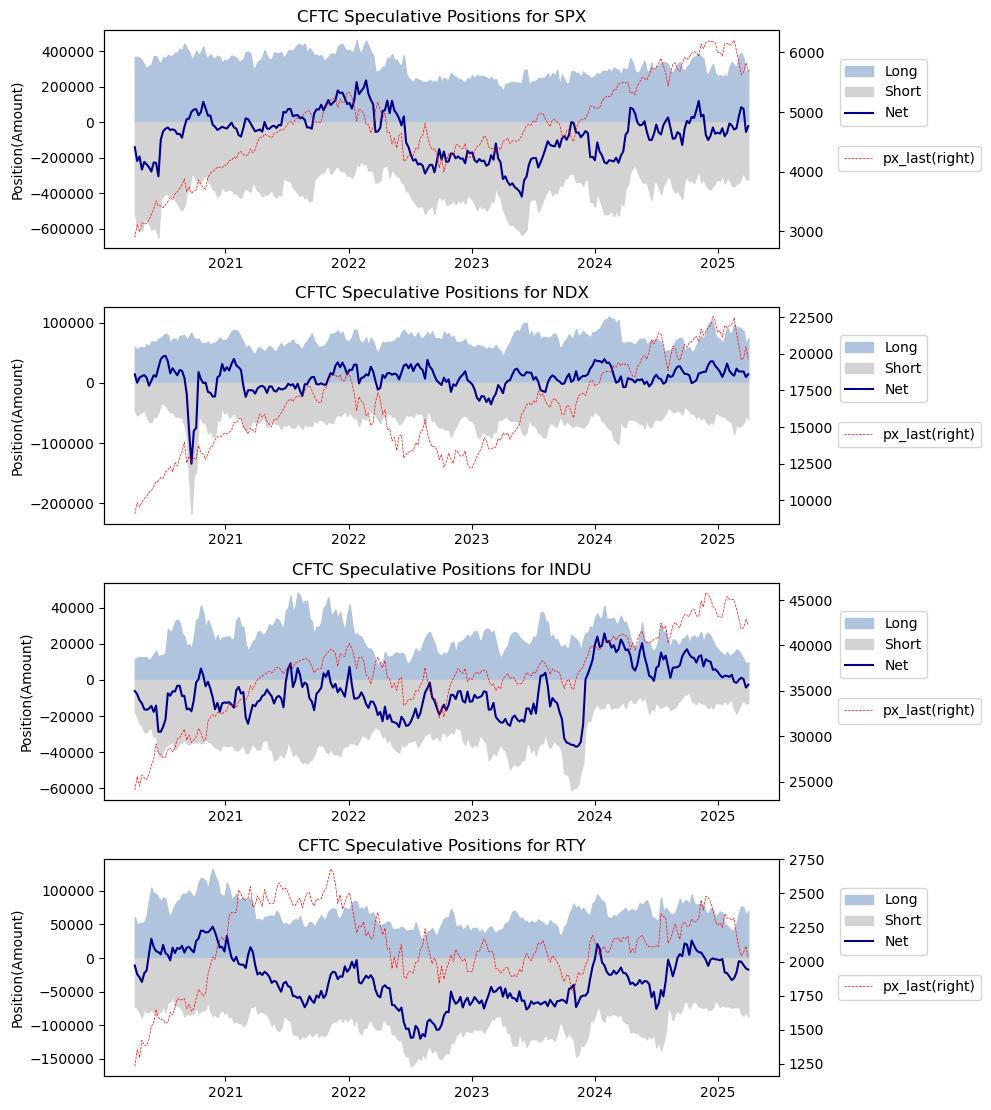

,Symbol,YK,Fut,Fut&Option,Name,Exch,Contract,Undl,MicroMini
0,ES,Index,IMM0E,IMMTE,S&P500 EMINI FUT Jun25,CME,"255,512",SPX,HWA
1,NQ,Index,IMM3N,IMMPN,NASDAQ 100 E-MINI Jun25,CME,"350,780",NDX,HWB
2,DM,Index,CBT1D,CBTOD,DJIA MINI e-CBOT Jun25,CBT,"192,650",INDU,HWI
3,RTY,Index,CFF6T,CFC6T,E-Mini Russ 2000 Jun25,CME,"91,970",RTY,HWR
4,HWA,Index,CF30C,CC30C,SP500 MIC EMIN FUTJun25,CME,"25,551",SPX,-
5,HWB,Index,CF30D,CC30D,NASD100 MICRO EMINJun25,CME,"35,078",NDX,-
6,HWI,Index,CF30E,CC30E,DJIA MICR MIN CBOTJun25,CBT,"19,265",INDU,-
7,HWR,Index,CF30F,CC30F,MICRO EMIN RUS2000Jun25,CME,"9,197",RTY,-


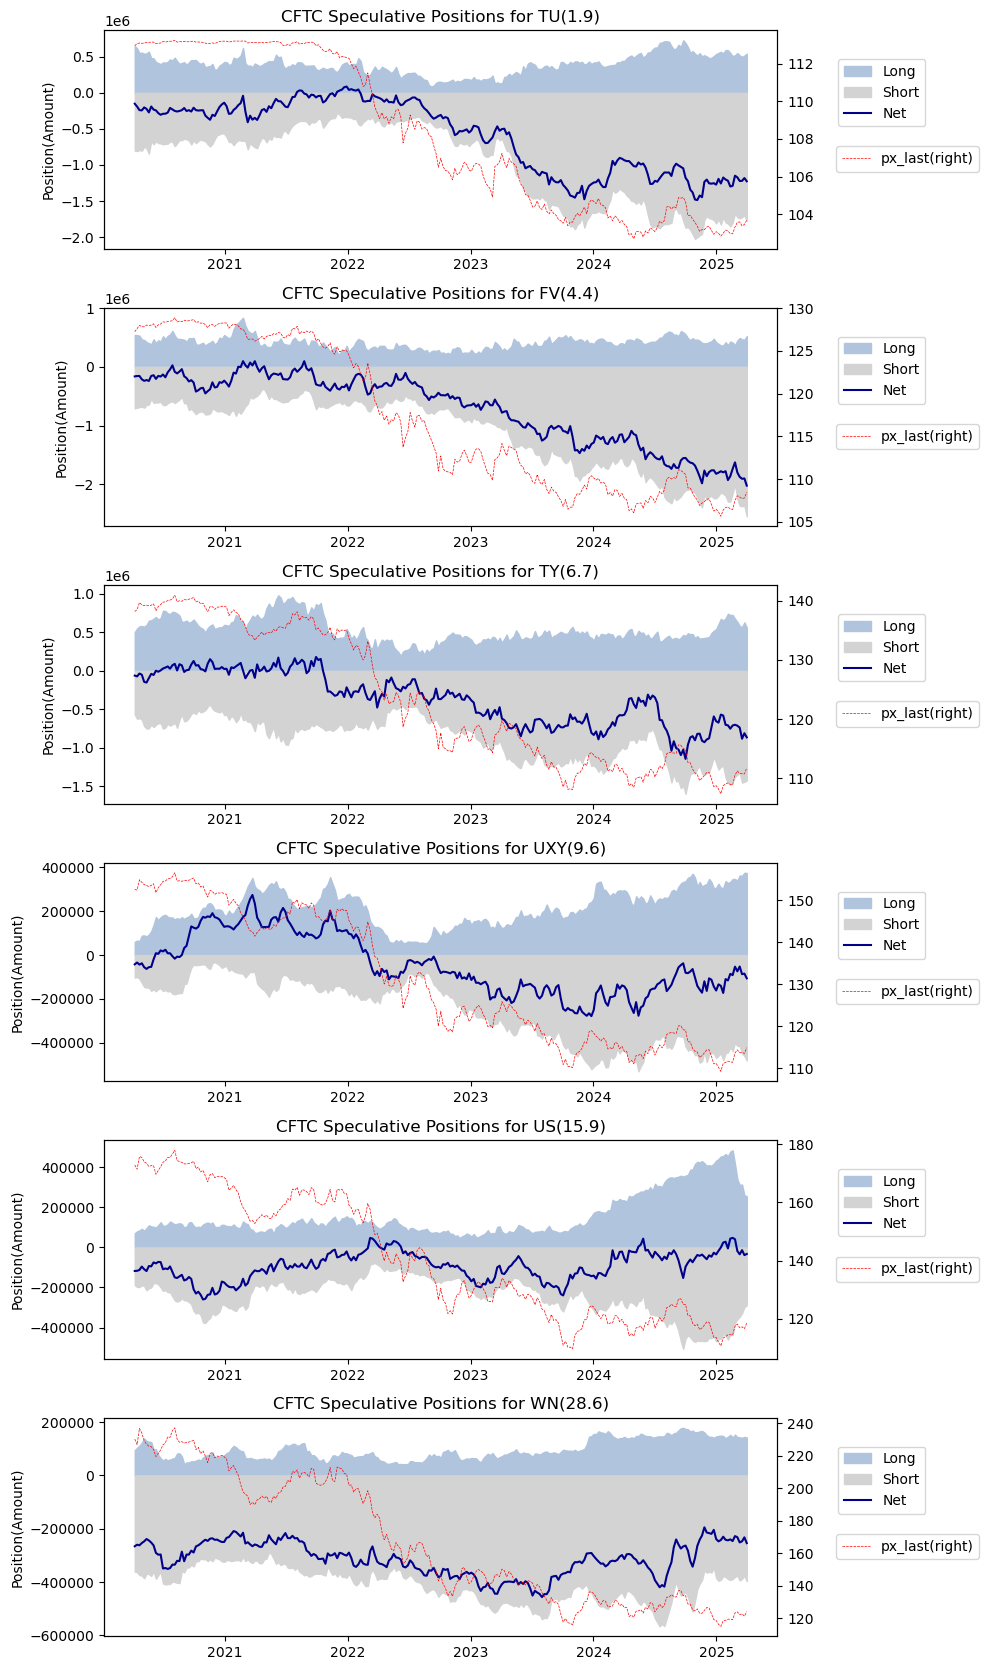

,Symbol,YK,Fut,Fut&Option,Name,Year,Exch,Contract
0,TU,Comdty,CBT42,CBTO2,US 2YR NOTE (CBT) Jun25,1.9,CBT,"208,141"
1,FV,Comdty,CBT55,CBTP5,US 5YR NOTE (CBT) Jun25,4.4,CBT,"109,336"
2,TY,Comdty,CBT4T,CBTPT,US 10YR NOTE (CBT)Jun25,6.7,CBT,"113,047"
3,UXY,Comdty,CFF4Z,CFC4Z,US 10yr Ultra Fut Jun25,9.6,CBT,"116,500"
4,US,Comdty,CBT3T,CBTOT,US LONG BOND(CBT) Jun25,15.9,CBT,"120,594"
5,WN,Comdty,CBT3B,CBTOB,US ULTRA BOND CBT Jun25,28.6,CBT,"126,875"


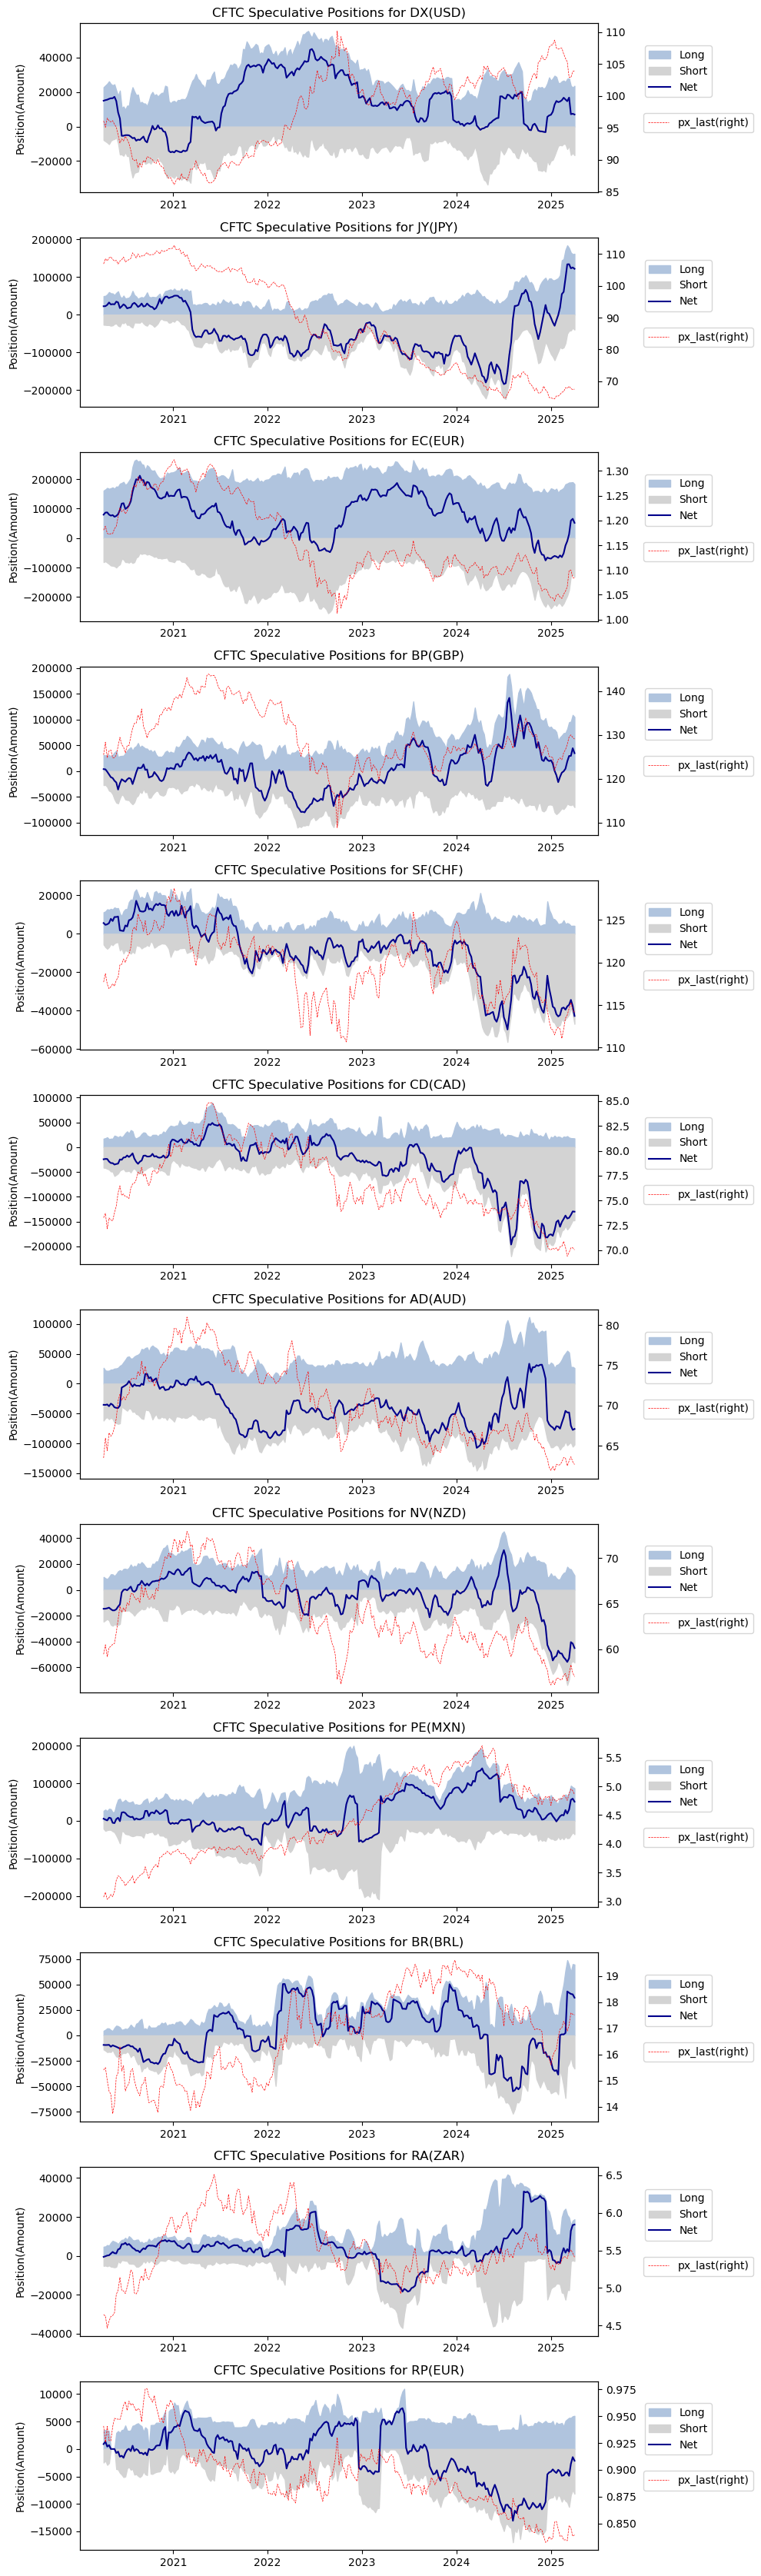

,Symbol,YK,Fut,Fut&Option,Name,Crncy,Exch,Contract
0,DX,Curncy,NYC2U,NYCOU,DOLLAR INDEX Jun25,USD,FNX,"102,768"
1,JY,Curncy,IMM5J,IMMOJ,JPN YEN CURR FUT Jun25,JPY,CME,"85,794"
2,EC,Curncy,IMMBE,IMMPF,EURO FX CURR FUT Jun25,EUR,CME,"137,356"
3,BP,Curncy,IMM5P,IMMOP,BP CURRENCY FUT Jun25,GBP,CME,"80,500"
4,SF,Curncy,IMM4S,IMMTS,CHF CURRENCY FUT Jun25,CHF,CME,"146,512"
5,CD,Curncy,IMM3C,IMMOC,C$ CURRENCY FUT Jun25,CAD,CME,"70,495"
6,AD,Curncy,IMM6A,IMMOA,AUDUSD Crncy Fut Jun25,AUD,CME,"60,225"
7,NV,Curncy,IMM6Z,IMMTZ,NEW ZEALAND $ FUT Jun25,NZD,CME,"55,870"
8,PE,Curncy,IMM6M,IMMPM,MEXICAN PESO FUT Jun25,MXN,CME,"24,155"
9,BR,Curncy,IMM1V,IMMOV,BRAZIL REAL FUT May25,BRL,CME,"17,050"


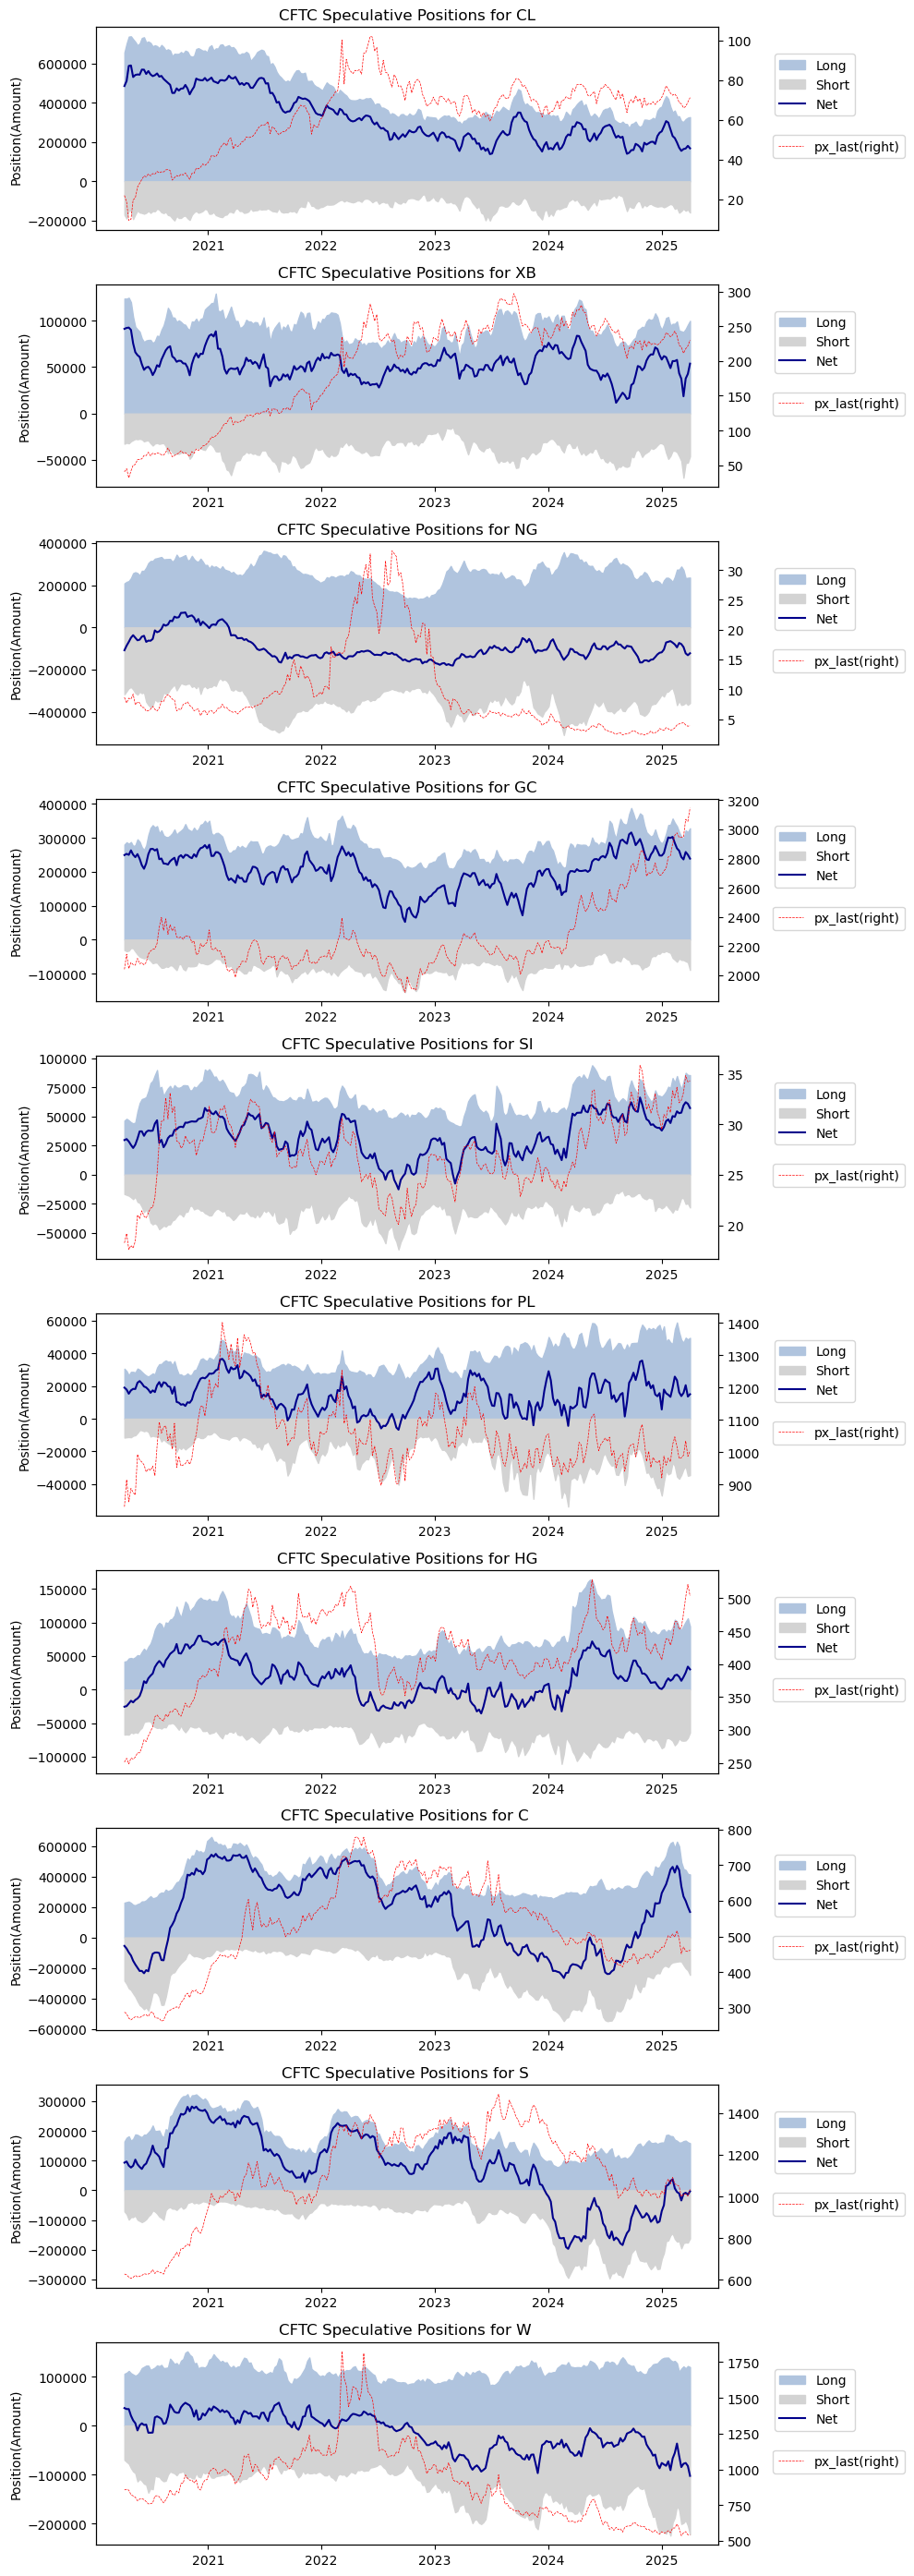

,Symbol,YK,Fut,Fut&Option,Name,Exch,Contract
0,CL,Comdty,NYM1C,NYMOC,WTI CRUDE FUTURE May25,NYM,"61,990"
1,XB,Comdty,NYM2X,NYMOX,GASOLINE RBOB FUT May25,NYM,"86,289"
2,NG,Comdty,NYM1N,NYMON,NATURAL GAS FUTR May25,NYM,"38,370"
3,GC,Comdty,CEI1G,CMXOG,GOLD 100 OZ FUTR Jun25,CMX,"303,540"
4,SI,Comdty,CEI1S,CMXOS,SILVER FUTURE May25,CMX,"146,150"
5,PL,Comdty,NYM3P,NYMOP,PLATINUM FUTURE Jul25,NYM,"45,730"
6,HG,Comdty,CEI1C,CMXOC,COPPER FUTURE May25,CMX,"110,050"
7,C,Comdty,CBT1C,CBTOC,CORN FUTURE May25,CBT,"23,012"
8,S,Comdty,CBT1S,CBTOS,SOYBEAN FUTURE May25,CBT,"48,850"
9,W,Comdty,CBT1W,CBTOW,WHEAT FUTURE(CBT) May25,CBT,"26,450"


True

In [134]:
d_from = (pd.Timestamp.today()-pd.DateOffset(years=5)).strftime("%Y%m%d")
d_to = pd.Timestamp.today().strftime("%Y%m%d")
html = "<h3><u>CFTC as of " + date.today().strftime("%Y%m%d") + "</u></h3>"


def f(List,AC,html):
# AC 1:EQ, 2:SB, 3:FX
    List = pd.DataFrame(List, columns=["Symbol", "YK", "Fut", "Fut&Option"])  # YK=YellowKey
    S = List["Symbol"]
    T = S + "A " + List["YK"]
   
    if AC =="EQ":
        BDP = blp.bdp(tickers=T.tolist(), flds=["name", "exch_code", "contract_value", "undl_spot_ticker"]).loc[T, :]
        List[["Name", "Exch", "Contract", "Undl"]] = np.array(BDP)
        List["MicroMini"] = "-"
        List["Adj"] = "-"
        for i in range(len(List)):
            tmp = List.loc[List["Undl"]==List.loc[i,"Undl"],"Symbol"].values[1]
            if tmp != List.loc[i,"Symbol"]:
                List.loc[i,"MicroMini"] = tmp
                List.loc[i,"Adj"] = 0.1
    elif AC =="SB":
        BDP = blp.bdp(tickers=T.tolist(), flds=["name","mty_years","exch_code", "contract_value"]).loc[T, :]
        List[["Name","Year", "Exch", "Contract"]] = np.array(BDP)
    elif AC =="FX":
        BDP = blp.bdp(tickers=T.tolist(), flds=["name","base_crncy","exch_code", "contract_value"]).loc[T, :]
        List[["Name","Crncy", "Exch", "Contract"]] = np.array(BDP)
        List.loc[List.Symbol=="DX","Crncy"] = "USD"
    else:
        BDP = blp.bdp(tickers=T.tolist(), flds=["name","exch_code", "contract_value"]).loc[T, :]
        List[["Name", "Exch", "Contract"]] = np.array(BDP)
        
    P = ["L","S","N"] 
    tmp = List["Fut"]
    T = [i + "NC" + j + " Index" for i in tmp for j in P]

    if AC =="EQ":
        for i in range(len(List)):
            tmp = List.loc[List["Undl"]==List.loc[i,"Undl"],"Symbol"].values[1]

    BDH = blp.bdh(tickers=T, flds="px_last", start_date=d_from,end_date=d_to).reset_index()
    BDH = BDH[["index"]+T]
        
    T = [f"{List.loc[i, 'Symbol']}1 {List.loc[i, 'YK']}" for i in range(len(List))]
    BDH1 = blp.bdh(tickers=T, flds="px_last", start_date=d_from,end_date=d_to, Calendar="5D",Fill="P").reset_index()
    BDH1 = BDH1[["index"]+T]
    BDH1.columns = ["Date"] + [ i + "_last" for i in S]
    
    df = BDH.copy()
    df.columns = ["Date"] + [f'{i}_{j}' for i in List["Symbol"] for j in P]
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x: -x if x.name[-1] == 'S' else x)


    # display(df.tail())
    # print(len(df),len(BDH1))
    # display(df.tail())
    # display(BDH1.tail())
    df = df.merge(BDH1[["Date"] + [ i + "_last" for i in S]])

    # display(df.tail())
    df.fillna(0, inplace=True)
    # display(df.tail())
    

    if AC =="FX":
        df1 = df[[col for col in df.columns if "DX_" not in col and "RP" not in col]]
        df1 = df1[[col for col in df1.columns if "_TA" in col]]
        df["USD_TA"] = -df1.sum(axis=1)
    
    if AC =="EQ":
        S = List[List.MicroMini!="-"].Symbol
    else:
        S = List.Symbol
    
    Date = df["Date"]
    fig, ax = plt.subplots(len(S), 1,figsize=(10,len(S)*2.8),tight_layout=True)

    for i,s in enumerate(S):
        if AC =="EQ":
            MM = List.loc[List["Symbol"]==s,"MicroMini"].values[0]
            if MM == "-":
                SL, SS, SN = [df[s+"_"+p] for p in P]
            else:
                Adj = List.loc[List["Symbol"]==s,"Adj"].values[0]
                SL, SS, SN = [df[s+"_"+p] + df[MM+"_"+p]*Adj for p in P]
        else:
            SL, SS, SN = [df[s+"_"+p] for p in P]

        
        ax[i].stackplot(Date, SL, labels=["Long"], color="lightsteelblue")
        ax[i].stackplot(Date, SS, labels=["Short"], color="lightgrey")
        ax[i].plot(Date, SN, label="Net", color="darkblue")
        ax2 = ax[i].twinx()
        ax2.plot(Date, df[s+"_last"], label="px_last(right)", color="red", linestyle="--", linewidth=0.5) 
        
        if AC=="EQ":
            tmp = List.loc[List["Symbol"]==s,"Undl"].tolist()[0]
        else:
            tmp = List.loc[List["Symbol"]==s,"Symbol"].tolist()[0]
            
        if AC=="SB":
            tmp += "("+ str(round(List.loc[List["Symbol"]==s,"Year"].tolist()[0],1))+")"
        elif AC=="FX":
            tmp += "("+ List.loc[List["Symbol"]==s,"Crncy"].tolist()[0]+")"

        ax[i].set_title("CFTC Speculative Positions for " + tmp)
        ax[i].set_ylabel("Position(Amount)")
        ax[i].legend(loc='upper left', bbox_to_anchor=(1.08, 0.9))
        ax2.legend(loc='upper right', bbox_to_anchor=(1.31, 0.5))
        fig.tight_layout()

    plt.savefig("tmp.png")
    with open("tmp.png", "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    html += f'<img src="data:image/png;base64,{encoded_string}" width="850">'
    os.remove("tmp.png")
    plt.show()


    if AC=="EQ":        
        html += List.drop('Adj', axis=1).style.format({c: '{:,.0F}' for c in ["Contract"]}).to_html()
        display(List.drop('Adj', axis=1).style.format({c: '{:,.0F}' for c in ["Contract"]}))
    else:
        html += List.style.format({"Contract": "{:,.0f}", "Year": "{:.1f}"}).to_html()
        display(List.style.format({"Contract": "{:,.0f}", "Year": "{:.1f}"}))

    for i in List["Symbol"].tolist():
        df[i+"_TA"] = df[i+"_N"] * df[i+"_last"] #Total Amount

    tmp = ["Date"] + [col for col in df.columns if any(substr in col for substr in ["_N", "_last", "_TA"])]
    return df[tmp], List, html

List = [
    ["ES", "Index", "IMM0E", "IMMTE"],
    ["NQ", "Index", "IMM3N", "IMMPN"],
    ["DM", "Index", "CBT1D", "CBTOD"],
    ["RTY", "Index", "CFF6T", "CFC6T"],
    ["HWA", "Index", "CF30C", "CC30C"],
    ["HWB", "Index", "CF30D", "CC30D"],
    ["HWI", "Index", "CF30E", "CC30E"],
    ["HWR", "Index", "CF30F", "CC30F"]
]

df_EQ,List,html =f(List,"EQ",html)


List = [
    ["TU", "Comdty", "CBT42", "CBTO2"],
    ["FV", "Comdty", "CBT55", "CBTP5"],
    ["TY", "Comdty", "CBT4T", "CBTPT"],
    ["UXY", "Comdty", "CFF4Z", "CFC4Z"],
    ["US", "Comdty", "CBT3T", "CBTOT"],
    ["WN", "Comdty", "CBT3B", "CBTOB"]
]
df_SB,List,html =f(List,"SB",html)


List = [
    ["DX", "Curncy", "NYC2U", "NYCOU"],
    ["JY", "Curncy", "IMM5J", "IMMOJ"],
    ["EC", "Curncy", "IMMBE", "IMMPF"],
    ["BP", "Curncy", "IMM5P", "IMMOP"],
    ["SF", "Curncy", "IMM4S", "IMMTS"],
    ["CD", "Curncy", "IMM3C", "IMMOC"],
    ["AD", "Curncy", "IMM6A", "IMMOA"],
    ["NV", "Curncy", "IMM6Z", "IMMTZ"],
    ["PE", "Curncy", "IMM6M", "IMMPM"],
    ["BR", "Curncy", "IMM1V", "IMMOV"],
    ["RA", "Curncy", "CFF4A", "CFC4A"],
    ["RP", "Curncy", "CFF8E", "CFC8E"],
]
df_FX,List_FX,html =f(List,"FX",html)


List = [
    ["CL", "Comdty", "NYM1C", "NYMOC"],
    ["XB", "Comdty", "NYM2X", "NYMOX"],
    ["NG", "Comdty", "NYM1N", "NYMON"],
    ["GC", "Comdty", "CEI1G", "CMXOG"],
    ["SI", "Comdty", "CEI1S", "CMXOS"],
    ["PL", "Comdty", "NYM3P", "NYMOP"],
    ["HG", "Comdty", "CEI1C", "CMXOC"],
    ["C ", "Comdty", "CBT1C", "CBTOC"],
    ["S ", "Comdty", "CBT1S", "CBTOS"],
    ["W ", "Comdty", "CBT1W", "CBTOW"]
]
df_CM,List,html =f(List,"CM",html)


tmp = "CFTC_" + date.today().strftime('%Y%m%d') + ".html"
with open(tmp, "w") as f:
    f.write(html)
webbrowser.open('file://' + os.path.realpath(tmp))